1. Import Necessary Libraries

In [1]:
# 1. Import Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

2. Load Data

In [2]:
train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
test_ID = test['Id']
train_ID = train['Id']

3. Initial Data Overview

In [3]:
print("Train shape:", train.shape)
print("Test shape:", test.shape)
train.head()

Train shape: (1460, 81)
Test shape: (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


4. Visualize Target Variable (SalePrice)

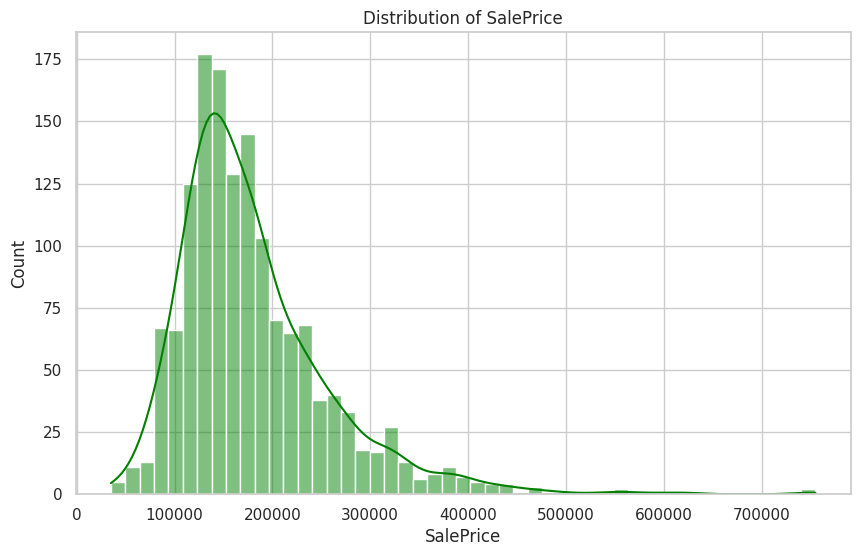

In [4]:
plt.figure(figsize=(10,6))
sns.histplot(train['SalePrice'], kde=True, color='green')
plt.title("Distribution of SalePrice")
plt.show()

5. Correlation Matrix (Top 10 Features)

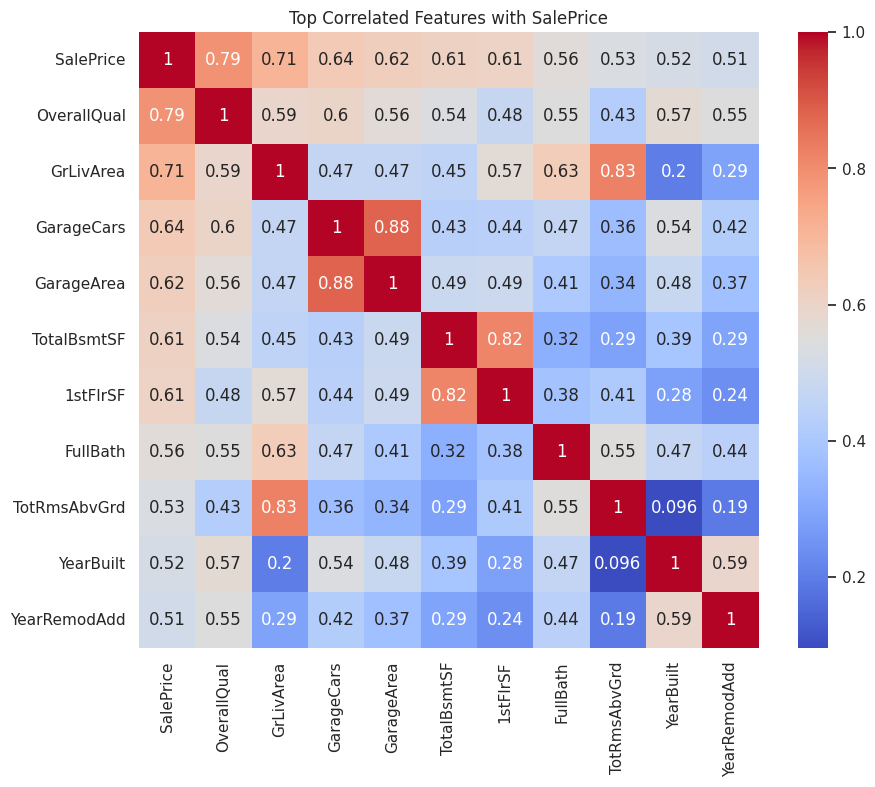

In [5]:
numeric_train = train.select_dtypes(include=[np.number])  # keep only numeric
corrmat = numeric_train.corr()
top_corr_features = corrmat['SalePrice'].sort_values(ascending=False)[:11]

# Plot heatmap of top correlated features
plt.figure(figsize=(10,8))
sns.heatmap(numeric_train[top_corr_features.index].corr(), annot=True, cmap='coolwarm')
plt.title("Top Correlated Features with SalePrice")
plt.show()

6. Handle Missing Data

In [6]:
all_data = pd.concat([train.drop('SalePrice', axis=1), test])
print("Total missing values:")
missing = all_data.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
print(missing)

Total missing values:
PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
MasVnrType      1766
FireplaceQu     1420
LotFrontage      486
GarageFinish     159
GarageQual       159
GarageCond       159
GarageYrBlt      159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Functional         2
Utilities          2
GarageArea         1
GarageCars         1
Electrical         1
KitchenQual        1
TotalBsmtSF        1
BsmtUnfSF          1
BsmtFinSF2         1
BsmtFinSF1         1
Exterior2nd        1
Exterior1st        1
SaleType           1
dtype: int64


7. Impute Missing Values

In [7]:
# Categorical: fill with 'None'
for col in all_data.select_dtypes(include='object').columns:
    all_data[col].fillna('None', inplace=True)

# Numerical: fill with median
for col in all_data.select_dtypes(exclude='object').columns:
    all_data[col].fillna(all_data[col].median(), inplace=True)

8. Feature Engineering

In [8]:
# TotalSF = Total square feet
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

9. Label Encode Categorical Features

In [9]:
cols = all_data.select_dtypes(include='object').columns
for col in cols:
    lbl = LabelEncoder()
    all_data[col] = lbl.fit_transform(all_data[col])

10. Feature Scaling

In [10]:
scaler = StandardScaler()
all_data_scaled = scaler.fit_transform(all_data)

11. Split Back into Train and Test

In [11]:
X = all_data_scaled[:train.shape[0]]
X_test = all_data_scaled[train.shape[0]:]
y = np.log1p(train['SalePrice'])  # log-transform for stability

12. XGBoost Regressor Model

In [12]:
model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Cross-Validation RMSE
score = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5))
print("CV RMSE Score: {:.4f}".format(score.mean()))

# Fit the model
model.fit(X, y)

CV RMSE Score: 0.1236


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

13. Predict on Test Set

In [13]:
preds = model.predict(X_test)
final_preds = np.expm1(preds)  # Inverse of log1p

14. Create submission.csv

In [14]:
submission = pd.DataFrame({
    'Id': test_ID,
    'SalePrice': final_preds
})
submission.to_csv("submission.csv", index=False)
print("submission.csv created.")

submission.csv created.
